# Finetuning VGG's Last Layer

In this exercise, we'll fine tune the final layer of VGG (since it's already a linear layer using softmax activation!) as opposed to adding one outside the model.

## Update Model Architecture

We'll start by importing the VGG model:

In [76]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_92 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_93 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_94 (ZeroPaddi (None, 64, 114, 114)      0         
__________

Cool, yep the last layer is a dense layer. Let's pop it off and replace it with our own, and lock all previous layers' so that we can only train the last layer while maintaining the benefits of layers trained on ImageNet features.

In [78]:
model.pop()
for layer in model.layers: layer.trainable=False

In [79]:
from keras.layers import Dense
model.add(Dense(2, activation="softmax"))

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_92 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_93 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_94 (ZeroPaddi (None, 64, 114, 114)      0         
__________

## Now let's train it

First, load data in from lesson 2b:

In [35]:
from importlib import reload
import utils; reload(utils)
from utils import get_data

path = '../../../data/dogscats/'
model_path = path + 'models/'

#trn_data = get_data(path+'train')
#val_data = get_data(path+'valid')
#val_data.shape

In [36]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

#save_array(model_path+'train_data.bc', trn_data)
#save_array(model_path+'valid_data.bc', val_data)
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')
val_data.shape

(2000, 3, 224, 224)

...and one-hot-encoded labels:

In [83]:
import numpy as np
from utils import get_batches

from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# Load up the labels
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

# Load the batches for actual training
from keras.preprocessing import image
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


Now, compile the model:

In [86]:
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)
model.compile(optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])

...and Train! (creating a function to make retraining easy)

In [87]:
fit_batch_size = 250
def fit_model(model, batches, val_batches, epochs=1):
    model.fit_generator(batches, 
                        steps_per_epoch=batches.n/fit_batch_size, 
                        epochs=epochs, 
                        validation_data=val_batches, 
                        validation_steps=val_batches.n/fit_batch_size)

In [88]:
fit_model(model, batches, val_batches, epochs=4)

Epoch 1/4
92/92 [==============================] - 39s - loss: 0.1539 - acc: 0.9517 - val_loss: 0.0291 - val_acc: 0.9900
Epoch 2/4
92/92 [==============================] - 39s - loss: 0.1010 - acc: 0.9730 - val_loss: 0.0386 - val_acc: 0.9863
Epoch 3/4
92/92 [==============================] - 39s - loss: 0.1025 - acc: 0.9745 - val_loss: 0.0898 - val_acc: 0.9738
Epoch 4/4
92/92 [==============================] - 39s - loss: 0.0899 - acc: 0.9796 - val_loss: 0.0466 - val_acc: 0.9900


### Save the Model (Weights) Out to Disk

In [89]:
#model.save_weights(model_path + 'finetune1.h5')
#model.load_weights(model_path + 'finetune1.h5')

### Evaluate the results

In [90]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 8s     


[0.051719786184896296, 0.98399999999999999]

In [91]:
preds = model.predict_classes(val_data, batch_size=100)
probs = model.predict_proba(val_data, batch_size=100)[:,0]

2000/2000 [==============================] - 7s     


[[987  13]
 [ 19 981]]


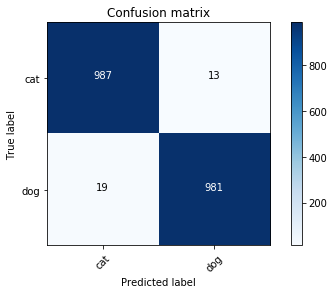

In [92]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Run on Test Data

In [94]:
# Load up the labels
# Use batch size of 1 since we're just doing preprocessing on the CPU
tst_batches = get_batches(path+'test-redux', shuffle=False, batch_size=1)
tst_classes = tst_batches.classes
tst_labels = onehot(tst_classes)

# Load the data
tst_data = get_data(path+'test-redux')

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.


In [95]:
tst_probs = model.predict_proba(tst_data, batch_size=100)[:,0]

12500/12500 [==============================] - 49s    


In [97]:
prob_dog = np.array(1-tst_probs)
prob_dog = prob_dog.clip(min=0.02, max=0.98)

idx = [int(fn.split('/')[1].split('.')[0]) for fn in tst_batches.filenames]

prob_dog_idx = np.c_[np.array(idx), prob_dog]

In [98]:
prob_dog_idx[:5]

array([[  3.4960e+03,   2.0000e-02],
       [  1.0203e+04,   9.8000e-01],
       [  1.9230e+03,   2.0000e-02],
       [  2.0560e+03,   9.8000e-01],
       [  8.5060e+03,   2.0000e-02]])

In [99]:
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

## Result?

Top 250 people on Kaggle! (225th to be precise!)

Next up, training more layers?